In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandana.loaders import osm
import pandana
%pylab inline

import numpy as np
import osmnx as ox
import networkx as nx
import peartree
import sys, os
import geopandas as gpd
import rasterio
from pandana.loaders import osm
from shapely.geometry import Point
#import mplleaflet as mpll
from osgeo import ogr
from math import ceil, cos, pi
import geocoder

import GOSTnet as gn
from make_fishnet import make_fishnet
from rasterio.features import rasterize
from rasterio.plot import show
import rasterio

Populating the interactive namespace from numpy and matplotlib
peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 


### Workflow to plot time to nearest N amenity for cities
* Map it as a smooth travel time surface
* Include walk time to nearest node
* Do OD calculations from each pixel to the set of nearest nodes
* Burn it back into a raster

In [2]:
boundary_gdf = ox.gdf_from_place('Piedmont, California')

In [3]:
raster_path = ('data/PIED_raster.tif')
raster_orig = rasterio.open(raster_path)

In [4]:
area_points = gpd.read_file('data/PIED_points/points_PIED.shp')
area_points.head()

,pointid,grid_code,geometry
0,1,-122.210148,POINT (-122.2281674999999 37.83298450000001)
1,2,-122.210148,POINT (-122.2280845 37.83298450000001)
2,3,-122.210148,POINT (-122.2284164999999 37.8329015000001)
3,4,-122.210148,POINT (-122.2283335 37.8329015000001)
4,5,-122.210148,POINT (-122.2282504999999 37.8329015000001)


In [5]:
boundary_poly = boundary_gdf.loc[0,'geometry']
coords = (boundary_poly.bounds[1], boundary_poly.bounds[0], boundary_poly.bounds[3], boundary_poly.bounds[2])
coords

(37.812276, -122.249374, 37.833026, -122.210148)

#### 2. Get POIs, road network

In [6]:
# RESIDENTIAL AMENITIES

residential_amenities = ['restaurant','bank','atm','cafe','bus_station','fast_food','pharmacy','school',
                        'kindergarten','pub','hospital','bar','marketplace','dentist','place_of_worship']

residential_shops = ['supermarket','yes','hairdresser','convenience','clothes','beauty','bakery']
residential_leisure = ['park','playground','sports_centre','pitch']

POIs_res_amenity = osm.node_query(coords[0], coords[1], coords[2], coords[3],tags = '"amenity"~"{}"'.format('|'.join(residential_amenities)))
POIs_res_shop = osm.node_query(coords[0], coords[1], coords[2], coords[3],tags = '"shop"~"{}"'.format('|'.join(residential_shops)))
POIs_res_leisure = osm.node_query(coords[0], coords[1], coords[2], coords[3],tags = '"leisure"~"{}"'.format('|'.join(residential_leisure)))

POIs_res_amenity = POIs_res_amenity[['amenity','name','lat','lon']]
POIs_res_amenity.rename(columns={'amenity':'type'},inplace=True)

POIs_res_shop = POIs_res_shop[['shop','name','lat','lon']]
POIs_res_shop.rename(columns={'shop':'type'},inplace=True)

POIs_res_leisure = POIs_res_leisure[['leisure','name','lat','lon']]
POIs_res_leisure.rename(columns={'leisure':'type'},inplace=True)

pois_res = POIs_res_amenity.append(POIs_res_shop)
pois_res = pois_res.append(POIs_res_leisure)

In [7]:
pois_res.head(1)

,type,name,lat,lon
id,,,,
358819251,school,Millennium Alternate High School,37.822905,-122.233678


In [8]:
pois_res = gpd.GeoDataFrame(pois_res)
pois_res['geometry'] = (list(zip(pois_res.lon,pois_res.lat)))
pois_res['geometry'] = pois_res.geometry.apply(lambda x: Point(x))

In [9]:
pois_res['type'].value_counts().head()

restaurant     14
hairdresser     5
convenience     3
school          3
playground      3
Name: type, dtype: int64

#### 3. Create graph
* Convert to time


In [10]:
# Create graph
G = ox.graph_from_polygon(boundary_poly, network_type = 'walk')

In [11]:
G = gn.convert_network_to_time(G, graph_type = 'walk',distance_tag = 'length')

In [12]:
ox.plot_graph_folium(G)

In [41]:
#nx.write_gpickle(G,'data/city_access/UB/G_pickle')

#### 4. Import origin points

In [13]:
area_points.drop(columns='grid_code',inplace=True)

In [203]:
pois_res.to_csv('data/city_access/pois_res.csv')

#### 5. Attach nearest nodes to Os and Ds (plus get the walk-time to NN)

In [14]:
# Origins
area_points = gn.pandana_snap(G, area_points, add_dist_to_node_col=True, source_crs='epsg:4326', target_crs = 'epsg:32646')

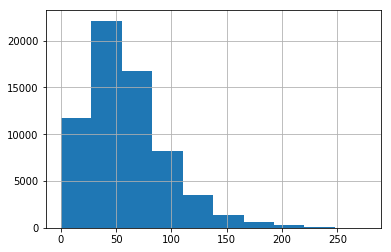

In [15]:
area_points.NN_dist.hist()

In [16]:
# Destinations
pois_res = gn.pandana_snap(G, pois_res, add_dist_to_node_col=True, source_crs= 'epsg:4326', target_crs = 'epsg:32646')


#### 6. Calculate travel times

In [17]:
gn.example_edge(G)

(4679800850, 53018411, {'osmid': 6327300, 'name': 'Lake Avenue', 'highway': 'residential', 'oneway': False, 'length': 9.569, 'time': 7.655200000000001, 'mode': 'walk'})


In [18]:
%%time
OD = gn.calculate_OD(G, list(area_points.NN), list(pois_res.NN), 0, weight='time')
OD_df = pd.DataFrame(OD, index = area_points.pointid, columns = pois_res.index)

KeyboardInterrupt: 

In [ ]:
OD_df.head()

In [125]:
area_points.head()

,pointid,geometry,NN,origin_walk_distance,min_travel_time,min_travel_times_road,nearest_destination_ID,destination_walk_distance,destination_ID
0,1,POINT (-122.2281674999999 37.83298450000001),53065785,160.994993,6.730951,NaN,NaN,NaN,NaN
1,2,POINT (-122.2280845 37.83298450000001),53065785,160.050935,6.718363,1591.9288,2.810182e+09,397.850336,2.810182e+09
2,3,POINT (-122.2284164999999 37.8329015000001),53065785,156.348684,6.669000,1591.9288,2.810182e+09,397.850336,2.810182e+09
3,4,POINT (-122.2283335 37.8329015000001),53065785,154.070177,6.638620,1591.9288,2.810182e+09,397.850336,2.810182e+09
4,5,POINT (-122.2282504999999 37.8329015000001),53065785,152.200735,6.613694,1591.9288,2.810182e+09,397.850336,2.810182e+09


In [122]:
area_points['destination_ID'] = OD_df.idxmin(axis=1)
area_points['min_travel_times_road'] = OD_df.min(axis = 1)
area_points.rename(columns={'NN_dist':'origin_walk_distance'},inplace=True)

In [123]:
destination_walk_distances_dict = dict(zip(set(pois_res.index),set(pois_res.NN_dist)))

In [124]:
area_points['destination_walk_distance'] = area_points.nearest_destination_ID.map(destination_walk_distances_dict)

In [137]:
area_points['walk_time_origin'] = ((area_points.origin_walk_distance / 1000 ) / 4.5) * 60 * 60      # in seconds
area_points['walk_time_destination'] = ((area_points.destination_walk_distance / 1000 ) / 4.5) * 60 * 60
area_points['walk_time'] = walk_time_origin + walk_time_destination

In [148]:
area_points['travel_time'] = area_points['min_travel_times_road'] + area_points['walk_time']
area_points['travel_time_MINS'] = area_points['travel_time'] / 60

In [150]:
area_points.set_geometry('geometry',inplace=True)

In [157]:
print(area_points.shape)
area_points.dropna(inplace=True)
print(area_points.shape)

(64608, 15)
(64607, 15)


In [160]:
area_points.columns

Index(['pointid', 'geometry', 'NN', 'origin_walk_distance', 'min_travel_time',
       'min_travel_times_road', 'nearest_destination_ID',
       'destination_walk_distance', 'destination_ID', 'min_travel_time_MINS',
       'walk_time_origin', 'walk_time_destination', 'walk_time', 'travel_time',
       'travel_time_MINS'],
      dtype='object')

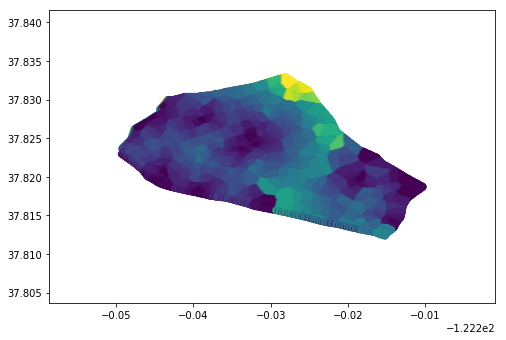

In [159]:
area_points.plot(column='min_travel_times_road',figsize=[8,8])

In [200]:
area_points.to_file('data/city_access/PIED_final.shp')

In [19]:
area_points = gpd.read_file('data/city_access/PIED_final.shp')

In [20]:
area_points.head()

,geometry
0,POINT (-122.2280845 37.83298450000001)
1,POINT (-122.2284164999999 37.8329015000001)
2,POINT (-122.2283335 37.8329015000001)
3,POINT (-122.2282504999999 37.8329015000001)
4,POINT (-122.2281674999999 37.8329015000001)


In [161]:
rst_fn = os.path.join(pth,'PIED_raster.tif')
out_fn = os.path.join(pth,'PIED_travel_time.tif')

# Update metadata
rst = rasterio.open(rst_fn, 'r')
meta = rst.meta.copy()
D_type = rasterio.float64
meta.update(compress='lzw', dtype = D_type, count = 2)

with rasterio.open(out_fn, 'w', **meta) as out:
    with rasterio.open(rst_fn, 'r') as pop:
        
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(area_points.geometry, area_points.min_travel_time))
        
        rst1 = rst.read(1).astype(D_type)
        cpy = rst1.copy()

        travel_times = rasterize(shapes=shapes, fill=0, out=cpy, transform=out.transform)

        out.write_band(1, travel_times)

NameError: name 'pth' is not defined

In [232]:
rst.crs

CRS.from_dict(init='epsg:4326')

#### 7. Rasterize

In [162]:
pth = 'data'

In [ ]:
image = features.rasterize(
                ((g, 255) for g, v in shapes),
                out_shape=blue.shape, fill=0, transform=transform )

In [192]:
area_points.columns

Index(['pointid', 'geometry', 'NN', 'origin_walk_distance', 'min_travel_time',
       'min_travel_times_road', 'nearest_destination_ID',
       'destination_walk_distance', 'destination_ID', 'min_travel_time_MINS',
       'walk_time_origin', 'walk_time_destination', 'walk_time', 'travel_time',
       'travel_time_MINS'],
      dtype='object')

In [183]:
rst_fn = os.path.join(pth,'PIED_raster.tif')
out_fn = os.path.join(pth,'PIED_travel_time.tif')

# Update metadata
rst = rasterio.open(rst_fn, 'r')
meta = rst.meta.copy()
#D_type = rasterio.float64
#meta.update(compress='lzw', dtype = D_type, count = 2)

with rasterio.open(out_fn, 'w', **meta) as out:
    with rasterio.open(rst_fn, 'r') as pop:
        
        # this is where we create a generator of geom, value pairs to use in rasterizing
        shapes = ((geom,value) for geom, value in zip(area_points.geometry, area_points.travel_time))
        
        rst1 = rst.read(1).astype(D_type)
        cpy = rst1.copy()

        travel_times = rasterize(shapes=shapes, fill=0, out=cpy, transform=out.transform)

        out.write_band(1, travel_times)

In [178]:
tt = rasterio.open(os.path.join(pth, 'PIED_travel_time.tif'))

In [179]:
tt.count

2

In [176]:
rast_arr = tt.read(2)

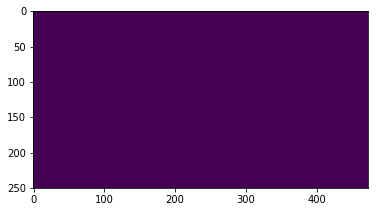

In [174]:
plt.imshow(rast_arr)

In [167]:
f,ax = plt.subplots(figsize = [9,6])

#im = show(tt, ax = ax, cmap=plt.cm.jet)
im = plt.imshow(rast_arr, cmap=plt.cm.jet)

# Add a colorbar
f.colorbar(im, ax=ax)
plt.title("Random town in California - Minutes drive to nearest amenity")

Text(0.5, 1.0, 'Random town in California - Minutes drive to nearest amenity')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1159c01e0> (for post_execute):


ValueError: arange: cannot compute length

ValueError: arange: cannot compute length